## EXPLORING mfcc_features

In [1]:
import sys
!{sys.executable} -m pip install librosa

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/b5/ba/c63c5786dfee4c3417094c4b00966e61e4a63efecee22cb7b4c0387dda83/librosa-0.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for audioread>=2.1.9 from https://files.pythonhosted.org/packages/57/8d/30aa32745af16af0a9a650115fbe81bde7c610ed5c21b381fca0196f3a7f/audioread-3.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for numba>=0.51.0 from https://files.pythonhosted.org/packages/97/c8/8740616c8436c86c1b9a62e72cb891177d2c34c2d24ddcde4c390371bf4c/numba-0.61.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/32/ea/564bacc26b676c06a00266a3f25fdfe91a9d9a2532ccea7ce6dd394541bc/scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━

In [3]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0e/6b/87fcddd34df9f53880fa1f0c23af7b6b96c935856473faf3914323588c40/torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/09/42/6908bff012a1dcc4fc515e52339652d7f488e208986542765c02ea775c2f/torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/ab/20/1873a49df9f1778c241543eaca14d613d657b9f9351c254952114251cb86/torchaudio-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/8b/54/b1ae86c0973cc6f0210b53d508ca3641fb6d0c56823f288d108bc7ab3cc8/typing_extensions-4.13.2-py3-none-any.whl.metadata
  Obtaining dependency 

In [60]:
!pip install matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/40/b8/53fa08a5eaf78d3a7213fd6da1feec4bae14a81d9805e567013811ff0e85/matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/41/b8/d5933559303a4ab18c799105f4c91ee0318cc95db4a2a09e300116625e7a/fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━

In [61]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import numpy as np
import pandas as pd

In [4]:
data = np.load("../features/mfcc_features.npz")
print(data.files) 

['X', 'y']


In [5]:
X = data['X']  
y = data['y']  
print("Original shape:", X.shape)
# print("Original shape:", y.shape)

Original shape: (7994, 40)


### have total of 7994 samples and 40 features 
### Next extracting MFCC features (from .mp3 to .npy file)

In [22]:
SOURCE_DIR = '../musicData/fma_small/'
DEST_DIR = '../features/lstm_mfcc'

# number of audio samples per second, to resample file to a smaller size and processing time while retaining enough frequency
SAMPLE_RATE = 22050

# MFCC Coefficients(Mel-Frequency Cepstral Coefficients) to extract per time frame
N_MFCC = 20
# The number of time frames per audio clip you want.
MAX_LEN = 130

os.makedirs(DEST_DIR, exist_ok=True)

def extract_mfcc(file_path):
    try:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)

        if mfcc.shape[1] < MAX_LEN:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_LEN - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_LEN]

        return mfcc.T  

    except Exception as e:
        print(f"Failed: {file_path} → {e}")
        return None

def process_all_files():
    count = 0
    print(f"Walking through: {SOURCE_DIR}")
    for root, _, files in os.walk(SOURCE_DIR):
        for fname in files:
            if fname.lower().endswith(".mp3"):  # case-insensitive
                full_path = os.path.join(root, fname)
                mfcc = extract_mfcc(full_path)
                if mfcc is not None:
                    out_name = os.path.splitext(fname)[0] + ".npy"
                    save_path = os.path.join(DEST_DIR, out_name)
                    np.save(save_path, mfcc)
                    print(f" Saved: {save_path}")
                    count += 1
    print(f"\n Done. Total processed: {count}")


process_all_files()

Walking through: ../musicData/fma_small/
 Saved: ../features/lstm_mfcc/073100.npy
 Saved: ../features/lstm_mfcc/073519.npy
 Saved: ../features/lstm_mfcc/073572.npy
 Saved: ../features/lstm_mfcc/073772.npy
 Saved: ../features/lstm_mfcc/073468.npy
 Saved: ../features/lstm_mfcc/073495.npy
 Saved: ../features/lstm_mfcc/073335.npy
 Saved: ../features/lstm_mfcc/073820.npy
 Saved: ../features/lstm_mfcc/073658.npy
 Saved: ../features/lstm_mfcc/073776.npy
 Saved: ../features/lstm_mfcc/073465.npy
 Saved: ../features/lstm_mfcc/073797.npy
 Saved: ../features/lstm_mfcc/073371.npy
 Saved: ../features/lstm_mfcc/073821.npy
 Saved: ../features/lstm_mfcc/073560.npy
 Saved: ../features/lstm_mfcc/073486.npy
 Saved: ../features/lstm_mfcc/073372.npy
 Saved: ../features/lstm_mfcc/073125.npy
 Saved: ../features/lstm_mfcc/073921.npy
 Saved: ../features/lstm_mfcc/073306.npy
 Saved: ../features/lstm_mfcc/073775.npy
 Saved: ../features/lstm_mfcc/073585.npy
 Saved: ../features/lstm_mfcc/073773.npy
 Saved: ../featu

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/tmp/ipykernel_4108405/3021678272.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/home/sdanayak/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Failed: ../musicData/fma_small/133/133297.mp3 → 
 Saved: ../features/lstm_mfcc/133781.npy
 Saved: ../features/lstm_mfcc/133102.npy
 Saved: ../features/lstm_mfcc/133442.npy
 Saved: ../features/lstm_mfcc/108967.npy
 Saved: ../features/lstm_mfcc/108230.npy
 Saved: ../features/lstm_mfcc/108473.npy
 Saved: ../features/lstm_mfcc/108500.npy
 Saved: ../features/lstm_mfcc/108490.npy
 Saved: ../features/lstm_mfcc/108460.npy
 Saved: ../features/lstm_mfcc/108428.npy
 Saved: ../features/lstm_mfcc/108060.npy
 Saved: ../features/lstm_mfcc/108489.npy
 Saved: ../features/lstm_mfcc/108015.npy
 Saved: ../features/lstm_mfcc/108495.npy
 Saved: ../features/lstm_mfcc/108878.npy
 Saved: ../features/lstm_mfcc/108426.npy
 Saved: ../features/lstm_mfcc/108957.npy
 Saved: ../features/lstm_mfcc/108425.npy
 Saved: ../features/lstm_mfcc/108488.npy
 Saved: ../features/lstm_mfcc/108415.npy
 Saved: ../features/lstm_mfcc/108528.npy
 Saved: ../features/lstm_mfcc/108837.npy
 Saved: ../features/lstm_mfcc/108302.npy
 Saved: 

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/tmp/ipykernel_4108405/3021678272.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/home/sdanayak/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Failed: ../musicData/fma_small/108/108925.mp3 → 
 Saved: ../features/lstm_mfcc/108503.npy
 Saved: ../features/lstm_mfcc/108318.npy
 Saved: ../features/lstm_mfcc/108059.npy
 Saved: ../features/lstm_mfcc/108906.npy
 Saved: ../features/lstm_mfcc/108532.npy
 Saved: ../features/lstm_mfcc/108464.npy
 Saved: ../features/lstm_mfcc/108839.npy
 Saved: ../features/lstm_mfcc/108342.npy
 Saved: ../features/lstm_mfcc/108022.npy
 Saved: ../features/lstm_mfcc/108303.npy
 Saved: ../features/lstm_mfcc/108845.npy
 Saved: ../features/lstm_mfcc/108307.npy
 Saved: ../features/lstm_mfcc/108499.npy
 Saved: ../features/lstm_mfcc/108471.npy
 Saved: ../features/lstm_mfcc/108531.npy
 Saved: ../features/lstm_mfcc/108341.npy
 Saved: ../features/lstm_mfcc/108836.npy
 Saved: ../features/lstm_mfcc/108840.npy
 Saved: ../features/lstm_mfcc/108745.npy
 Saved: ../features/lstm_mfcc/108496.npy
 Saved: ../features/lstm_mfcc/108477.npy
 Saved: ../features/lstm_mfcc/108308.npy
 Saved: ../features/lstm_mfcc/108525.npy
 Saved: 

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


 Saved: ../features/lstm_mfcc/011298.npy
 Saved: ../features/lstm_mfcc/011769.npy
 Saved: ../features/lstm_mfcc/011922.npy
 Saved: ../features/lstm_mfcc/011937.npy
 Saved: ../features/lstm_mfcc/011679.npy
 Saved: ../features/lstm_mfcc/011333.npy
 Saved: ../features/lstm_mfcc/011942.npy
 Saved: ../features/lstm_mfcc/011763.npy
 Saved: ../features/lstm_mfcc/011674.npy
 Saved: ../features/lstm_mfcc/011682.npy
 Saved: ../features/lstm_mfcc/011918.npy
 Saved: ../features/lstm_mfcc/011795.npy
 Saved: ../features/lstm_mfcc/011334.npy
 Saved: ../features/lstm_mfcc/011781.npy
 Saved: ../features/lstm_mfcc/011818.npy
 Saved: ../features/lstm_mfcc/011683.npy
 Saved: ../features/lstm_mfcc/011059.npy
 Saved: ../features/lstm_mfcc/143056.npy
 Saved: ../features/lstm_mfcc/143989.npy
 Saved: ../features/lstm_mfcc/143098.npy
 Saved: ../features/lstm_mfcc/143239.npy
 Saved: ../features/lstm_mfcc/143220.npy
 Saved: ../features/lstm_mfcc/143304.npy
 Saved: ../features/lstm_mfcc/143221.npy
 Saved: ../featu

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


 Saved: ../features/lstm_mfcc/021657.npy
 Saved: ../features/lstm_mfcc/021774.npy
 Saved: ../features/lstm_mfcc/021860.npy
 Saved: ../features/lstm_mfcc/021401.npy
 Saved: ../features/lstm_mfcc/021400.npy
 Saved: ../features/lstm_mfcc/021403.npy
 Saved: ../features/lstm_mfcc/021997.npy
 Saved: ../features/lstm_mfcc/021587.npy
 Saved: ../features/lstm_mfcc/021402.npy
 Saved: ../features/lstm_mfcc/021676.npy
 Saved: ../features/lstm_mfcc/021565.npy
 Saved: ../features/lstm_mfcc/019415.npy
 Saved: ../features/lstm_mfcc/019423.npy
 Saved: ../features/lstm_mfcc/019890.npy
 Saved: ../features/lstm_mfcc/019179.npy
 Saved: ../features/lstm_mfcc/019758.npy
 Saved: ../features/lstm_mfcc/019760.npy
 Saved: ../features/lstm_mfcc/019459.npy
 Saved: ../features/lstm_mfcc/019420.npy
 Saved: ../features/lstm_mfcc/019708.npy
 Saved: ../features/lstm_mfcc/019442.npy
 Saved: ../features/lstm_mfcc/019729.npy
 Saved: ../features/lstm_mfcc/019074.npy
 Saved: ../features/lstm_mfcc/019192.npy
 Saved: ../featu

/tmp/ipykernel_4108405/3021678272.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/home/sdanayak/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Saved: ../features/lstm_mfcc/099437.npy
 Saved: ../features/lstm_mfcc/099707.npy
 Saved: ../features/lstm_mfcc/099261.npy
 Saved: ../features/lstm_mfcc/099442.npy
 Saved: ../features/lstm_mfcc/099392.npy
 Saved: ../features/lstm_mfcc/099374.npy
 Saved: ../features/lstm_mfcc/099260.npy
 Saved: ../features/lstm_mfcc/099389.npy
 Saved: ../features/lstm_mfcc/099041.npy
 Saved: ../features/lstm_mfcc/099390.npy
 Saved: ../features/lstm_mfcc/099393.npy
 Saved: ../features/lstm_mfcc/099411.npy
 Saved: ../features/lstm_mfcc/099439.npy
 Saved: ../features/lstm_mfcc/099135.npy
 Saved: ../features/lstm_mfcc/099703.npy
 Saved: ../features/lstm_mfcc/099274.npy
 Saved: ../features/lstm_mfcc/099394.npy
 Saved: ../features/lstm_mfcc/099436.npy
 Saved: ../features/lstm_mfcc/099369.npy
 Saved: ../features/lstm_mfcc/099371.npy
 Saved: ../features/lstm_mfcc/099438.npy
 Saved: ../features/lstm_mfcc/099372.npy
 Saved: ../features/lstm_mfcc/099704.npy
 Saved: ../features/lstm_mfcc/099419.npy
 Saved: ../featu

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


 Saved: ../features/lstm_mfcc/029245.npy
 Saved: ../features/lstm_mfcc/029465.npy
 Saved: ../features/lstm_mfcc/029243.npy
 Saved: ../features/lstm_mfcc/029350.npy
 Saved: ../features/lstm_mfcc/029602.npy
 Saved: ../features/lstm_mfcc/029255.npy
 Saved: ../features/lstm_mfcc/029673.npy
 Saved: ../features/lstm_mfcc/029039.npy
 Saved: ../features/lstm_mfcc/029807.npy
 Saved: ../features/lstm_mfcc/029746.npy
 Saved: ../features/lstm_mfcc/029480.npy
 Saved: ../features/lstm_mfcc/029042.npy
 Saved: ../features/lstm_mfcc/029745.npy
 Saved: ../features/lstm_mfcc/029043.npy
 Saved: ../features/lstm_mfcc/029742.npy
 Saved: ../features/lstm_mfcc/144477.npy
 Saved: ../features/lstm_mfcc/144733.npy
 Saved: ../features/lstm_mfcc/144552.npy
 Saved: ../features/lstm_mfcc/144424.npy
 Saved: ../features/lstm_mfcc/144170.npy
 Saved: ../features/lstm_mfcc/144544.npy
 Saved: ../features/lstm_mfcc/144179.npy
 Saved: ../features/lstm_mfcc/144467.npy
 Saved: ../features/lstm_mfcc/144492.npy
 Saved: ../featu

[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)


 Saved: ../features/lstm_mfcc/054666.npy
 Saved: ../features/lstm_mfcc/054568.npy


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)


 Saved: ../features/lstm_mfcc/054463.npy
 Saved: ../features/lstm_mfcc/054436.npy
 Saved: ../features/lstm_mfcc/054155.npy
 Saved: ../features/lstm_mfcc/054236.npy
 Saved: ../features/lstm_mfcc/054464.npy
 Saved: ../features/lstm_mfcc/054365.npy
 Saved: ../features/lstm_mfcc/054874.npy
 Saved: ../features/lstm_mfcc/054160.npy
 Saved: ../features/lstm_mfcc/054475.npy
 Saved: ../features/lstm_mfcc/054482.npy
 Saved: ../features/lstm_mfcc/054438.npy
 Saved: ../features/lstm_mfcc/054433.npy
 Saved: ../features/lstm_mfcc/054665.npy
 Saved: ../features/lstm_mfcc/054468.npy
 Saved: ../features/lstm_mfcc/054496.npy
 Saved: ../features/lstm_mfcc/054466.npy
 Saved: ../features/lstm_mfcc/054625.npy
 Saved: ../features/lstm_mfcc/054467.npy
 Saved: ../features/lstm_mfcc/054624.npy
 Saved: ../features/lstm_mfcc/054064.npy
 Saved: ../features/lstm_mfcc/054154.npy
 Saved: ../features/lstm_mfcc/054159.npy
 Saved: ../features/lstm_mfcc/054578.npy
 Saved: ../features/lstm_mfcc/054031.npy
 Saved: ../featu

Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_4108405/3021678272.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/home/sdanayak/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Saved: ../features/lstm_mfcc/098565.npy
 Saved: ../features/lstm_mfcc/098617.npy
 Saved: ../features/lstm_mfcc/098550.npy
 Saved: ../features/lstm_mfcc/098576.npy
 Saved: ../features/lstm_mfcc/098549.npy
 Saved: ../features/lstm_mfcc/098619.npy
 Saved: ../features/lstm_mfcc/098026.npy
 Saved: ../features/lstm_mfcc/098236.npy
 Saved: ../features/lstm_mfcc/098655.npy
 Saved: ../features/lstm_mfcc/098626.npy
 Saved: ../features/lstm_mfcc/098667.npy
 Saved: ../features/lstm_mfcc/098028.npy
 Saved: ../features/lstm_mfcc/098838.npy
 Saved: ../features/lstm_mfcc/098620.npy
 Saved: ../features/lstm_mfcc/098627.npy
 Saved: ../features/lstm_mfcc/098579.npy
 Saved: ../features/lstm_mfcc/098770.npy
 Saved: ../features/lstm_mfcc/098552.npy
 Saved: ../features/lstm_mfcc/098339.npy
 Saved: ../features/lstm_mfcc/098567.npy


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_4108405/3021678272.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/home/sdanayak/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Saved: ../features/lstm_mfcc/098618.npy
 Saved: ../features/lstm_mfcc/098668.npy
 Saved: ../features/lstm_mfcc/098204.npy
 Saved: ../features/lstm_mfcc/098205.npy
 Saved: ../features/lstm_mfcc/098577.npy
 Saved: ../features/lstm_mfcc/098031.npy
 Saved: ../features/lstm_mfcc/098622.npy
 Saved: ../features/lstm_mfcc/098680.npy
 Saved: ../features/lstm_mfcc/098298.npy
 Saved: ../features/lstm_mfcc/098348.npy
 Saved: ../features/lstm_mfcc/098671.npy
 Saved: ../features/lstm_mfcc/098582.npy
 Saved: ../features/lstm_mfcc/098584.npy
 Saved: ../features/lstm_mfcc/098625.npy
 Saved: ../features/lstm_mfcc/098556.npy
 Saved: ../features/lstm_mfcc/098574.npy
 Saved: ../features/lstm_mfcc/098553.npy
 Saved: ../features/lstm_mfcc/098670.npy
 Saved: ../features/lstm_mfcc/098578.npy
 Saved: ../features/lstm_mfcc/098621.npy
 Saved: ../features/lstm_mfcc/098656.npy
 Saved: ../features/lstm_mfcc/098547.npy
 Saved: ../features/lstm_mfcc/098666.npy


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_4108405/3021678272.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/home/sdanayak/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Saved: ../features/lstm_mfcc/098569.npy
 Saved: ../features/lstm_mfcc/098300.npy
 Saved: ../features/lstm_mfcc/098580.npy
 Saved: ../features/lstm_mfcc/098624.npy
 Saved: ../features/lstm_mfcc/098681.npy
 Saved: ../features/lstm_mfcc/098228.npy
 Saved: ../features/lstm_mfcc/098669.npy
 Saved: ../features/lstm_mfcc/098238.npy
 Saved: ../features/lstm_mfcc/098301.npy
 Saved: ../features/lstm_mfcc/098229.npy
 Saved: ../features/lstm_mfcc/098573.npy
 Saved: ../features/lstm_mfcc/098227.npy
 Saved: ../features/lstm_mfcc/098299.npy
 Saved: ../features/lstm_mfcc/098297.npy
 Saved: ../features/lstm_mfcc/098557.npy
 Saved: ../features/lstm_mfcc/098554.npy
 Saved: ../features/lstm_mfcc/098583.npy
 Saved: ../features/lstm_mfcc/098551.npy
 Saved: ../features/lstm_mfcc/098613.npy
 Saved: ../features/lstm_mfcc/098077.npy
 Saved: ../features/lstm_mfcc/098349.npy
 Saved: ../features/lstm_mfcc/098235.npy
 Saved: ../features/lstm_mfcc/098701.npy
 Saved: ../features/lstm_mfcc/136331.npy
 Saved: ../featu

In [6]:
genre_df = pd.read_csv("../reports/1_Explore_Metadata/valid_track_genres.csv")

# Get unique genres and assign integer labels
unique_genres = sorted(genre_df['genre_top'].dropna().unique())
genre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}

# Map each track_id to a label
label_map = {
    row['track_id']: genre_to_id[row['genre_top']]
    for _, row in genre_df.iterrows()
}

print("Genre → ID mapping:")
print(genre_to_id)
print(f"Total labeled tracks: {len(label_map)}")


Genre → ID mapping:
{'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}
Total labeled tracks: 8000


In [7]:
import os

npy_files = os.listdir('../features/lstm_mfcc')
print("Sample .npy files:", npy_files[:5])


Sample .npy files: ['145730.npy', '091162.npy', '131436.npy', '055293.npy', '132779.npy']


In [8]:
class FMA_LSTM_Dataset(Dataset):
    def __init__(self, feature_dir, label_map):
        self.feature_dir = feature_dir
        self.label_map = label_map
        self.file_list = [
            f for f in os.listdir(feature_dir)
            if f.endswith(".npy") and int(os.path.splitext(f)[0]) in label_map
        ]
        print(f"Total .npy files with labels found: {len(self.file_list)}")
        print("Example file_list content:", self.file_list[:5])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        track_id = int(os.path.splitext(filename)[0])
        label = self.label_map[track_id]

        mfcc_path = os.path.join(self.feature_dir, filename)
        x = np.load(mfcc_path)  # shape: (130, 20)
        # normalizing to avoid divide by 0
        x = (x - np.mean(x)) / (np.std(x) + 1e-8) 
        
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(label, dtype=torch.long)
        return x_tensor, y_tensor

In [9]:
dataset = FMA_LSTM_Dataset(
    feature_dir='../features/lstm_mfcc',
    label_map=label_map
)

# Sanity check
print(len(dataset))
x, y = dataset[0]
print("MFCC shape:", x.shape)   # (130, 20)
print("Genre class:", y)

Total .npy files with labels found: 7997
Example file_list content: ['145730.npy', '091162.npy', '131436.npy', '055293.npy', '132779.npy']
7997
MFCC shape: torch.Size([130, 20])
Genre class: tensor(3)


In [10]:
## test train split

In [37]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)
x_batch, y_batch = next(iter(train_loader))
# print("Batch shape:", x_batch.shape)  
# print("Genre class labels:", y_batch[:5])

In [38]:
# creating custom NN which will be used
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=20, hidden_size=128, num_layers=3, num_classes=8, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                           bidirectional=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (hn, _) = self.lstm(x)       
        logits = self.fc(hn[-1])          
        return logits


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(num_classes=len(set(label_map.values())))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

In [41]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


Epoch 1/20
  Train Loss: 1.9642, Accuracy: 0.2289
  Val   Loss: 1.9182, Accuracy: 0.2650
Epoch 2/20
  Train Loss: 1.8831, Accuracy: 0.2867
  Val   Loss: 1.8883, Accuracy: 0.2725
Epoch 3/20
  Train Loss: 1.8458, Accuracy: 0.3037
  Val   Loss: 1.8969, Accuracy: 0.2850
Epoch 4/20
  Train Loss: 1.8599, Accuracy: 0.2950
  Val   Loss: 1.8897, Accuracy: 0.2812
Epoch 5/20
  Train Loss: 1.8476, Accuracy: 0.2997
  Val   Loss: 1.8255, Accuracy: 0.2875
Epoch 6/20
  Train Loss: 1.7706, Accuracy: 0.3250
  Val   Loss: 1.8091, Accuracy: 0.3150
Epoch 7/20
  Train Loss: 1.8001, Accuracy: 0.3183
  Val   Loss: 1.7846, Accuracy: 0.3256
Epoch 8/20
  Train Loss: 1.7680, Accuracy: 0.3328
  Val   Loss: 1.7760, Accuracy: 0.3269
Epoch 9/20
  Train Loss: 1.7192, Accuracy: 0.3497
  Val   Loss: 1.7306, Accuracy: 0.3506
Epoch 10/20
  Train Loss: 1.6980, Accuracy: 0.3602
  Val   Loss: 1.7725, Accuracy: 0.3456
Epoch 11/20
  Train Loss: 1.6816, Accuracy: 0.3713
  Val   Loss: 1.7345, Accuracy: 0.3531
Epoch 12/20
  Train

In [42]:
torch.save(model.state_dict(), '../models/lstm_genre_classifier_without_class_weights.pth') 

In [46]:
model.load_state_dict(torch.load('../models/lstm_genre_classifier.pth'))
model.to(device)
model.eval()

LSTMClassifier(
  (lstm): LSTM(20, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [47]:
y_preds = []
y_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.argmax(outputs, dim=1)

        y_preds.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_preds,
    target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
))


               precision    recall  f1-score   support

   Electronic       0.00      0.00      0.00       192
 Experimental       0.00      0.00      0.00       222
         Folk       0.11      1.00      0.21       183
      Hip-Hop       0.00      0.00      0.00       192
 Instrumental       0.00      0.00      0.00       200
International       0.00      0.00      0.00       210
          Pop       0.00      0.00      0.00       196
         Rock       0.00      0.00      0.00       205

     accuracy                           0.11      1600
    macro avg       0.01      0.12      0.03      1600
 weighted avg       0.01      0.11      0.02      1600



/home/sdanayak/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sdanayak/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sdanayak/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
with open('../reports/lstm_mfcc/lstm_classification_report_without_class_weights.txt', 'w') as f:
    f.write(classification_report(
        y_true,
        y_preds,
        target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
    ))

/home/sdanayak/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sdanayak/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sdanayak/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
from collections import Counter

# Extract class labels from train_set
train_labels = [label.item() if torch.is_tensor(label) else label for _, label in train_set]

# Count frequency of each class
label_counts = Counter(train_labels)

print("Train class distribution:")
for class_id, count in sorted(label_counts.items()):
    print(f"Class {class_id}: {count} samples")

Train class distribution:
Class 0: 807 samples
Class 1: 777 samples
Class 2: 817 samples
Class 3: 808 samples
Class 4: 800 samples
Class 5: 790 samples
Class 6: 804 samples
Class 7: 794 samples


### The above results we can clearly interpret the following
- **Precision = 0.00 for 7/8 classes:**  Model never predicted those classes at all.
- **Recall = 1.00 for Folk only:** Model predicted only 'Folk' — for every input
- **LSTM is biased towards a single class "Folk"**. Failing to learn useful decision boundaries between genres could be due to multiple reasons like, difficulty in learning MFCC patterns by model, model might be overfitting certain temporal patterns, loss function "CrossEntropyLoss" treats all errors equally and missclassification gets no penalty.
### Solution: 
using class_weights in cross entropy

In [50]:
# Extract true labels from the train set
y_train_labels = [y for _, y in train_set]
y_train_labels = [label.item() if torch.is_tensor(label) else label for label in y_train_labels]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
print("Class weights:", class_weights)
# Convert to torch tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

Class weights: [0.99086121 1.0291184  0.97873317 0.9896349  0.99953125 1.01218354
 0.99455846 1.00708438]


In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(num_classes=len(set(label_map.values())))
model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

In [53]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

Epoch 1/20
  Train Loss: 1.9535, Accuracy: 0.2323
  Val   Loss: 1.9003, Accuracy: 0.2712
Epoch 2/20
  Train Loss: 1.8681, Accuracy: 0.2937
  Val   Loss: 1.8564, Accuracy: 0.2869
Epoch 3/20
  Train Loss: 1.8382, Accuracy: 0.3108
  Val   Loss: 1.8278, Accuracy: 0.3075
Epoch 4/20
  Train Loss: 1.8085, Accuracy: 0.3195
  Val   Loss: 1.8474, Accuracy: 0.3162
Epoch 5/20
  Train Loss: 1.8779, Accuracy: 0.2836
  Val   Loss: 1.8873, Accuracy: 0.2731
Epoch 6/20
  Train Loss: 1.7917, Accuracy: 0.3284
  Val   Loss: 1.7962, Accuracy: 0.3125
Epoch 7/20
  Train Loss: 1.7549, Accuracy: 0.3416
  Val   Loss: 1.7581, Accuracy: 0.3356
Epoch 8/20
  Train Loss: 1.7638, Accuracy: 0.3436
  Val   Loss: 1.7433, Accuracy: 0.3400
Epoch 9/20
  Train Loss: 1.7625, Accuracy: 0.3409
  Val   Loss: 1.7470, Accuracy: 0.3438
Epoch 10/20
  Train Loss: 1.7281, Accuracy: 0.3477
  Val   Loss: 1.8060, Accuracy: 0.3200
Epoch 11/20
  Train Loss: 1.6902, Accuracy: 0.3717
  Val   Loss: 1.7421, Accuracy: 0.3531
Epoch 12/20
  Train

In [54]:
torch.save(model.state_dict(), '../models/lstm_genre_classifier_with_class_weights.pth') 

In [66]:
# Classification Report
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.argmax(outputs, dim=1)

        y_preds.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

genre_id_to_name = {
    0: 'Electronic',
    1: 'Experimental',
    2: 'Folk',
    3: 'Hip-Hop',
    4: 'Instrumental',
    5: 'International',
    6: 'Pop',
    7: 'Rock'
}

class_names = [genre_id_to_name[i] for i in sorted(genre_id_to_name)]
print(classification_report(
    y_true,
    y_preds,
    target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
))

               precision    recall  f1-score   support

   Electronic       0.35      0.36      0.36       192
 Experimental       0.39      0.25      0.30       222
         Folk       0.38      0.31      0.34       183
      Hip-Hop       0.57      0.67      0.61       192
 Instrumental       0.37      0.46      0.41       200
International       0.32      0.35      0.34       210
          Pop       0.25      0.08      0.12       196
         Rock       0.43      0.73      0.54       205

     accuracy                           0.40      1600
    macro avg       0.38      0.40      0.38      1600
 weighted avg       0.38      0.40      0.38      1600



In [67]:
with open('../reports/lstm_mfcc/lstm_classification_report_with_class_weights.txt', 'w') as f:
    f.write(classification_report(
        y_true,
        y_preds,
        target_names=[genre_id_to_name[i] for i in sorted(genre_id_to_name.keys())]
    ))

In [68]:
## confusion matrix

In [71]:
def evaluate_and_plot(model_path, model_label):
    # Reload model
    model = LSTMClassifier(input_size=20, hidden_size=128, num_layers=3, num_classes=8, dropout=0.3)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_label}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'../reports/lstm_mfcc/confusion_matrix_{model_label.replace(" ", "_").lower()}.png')
    plt.show()


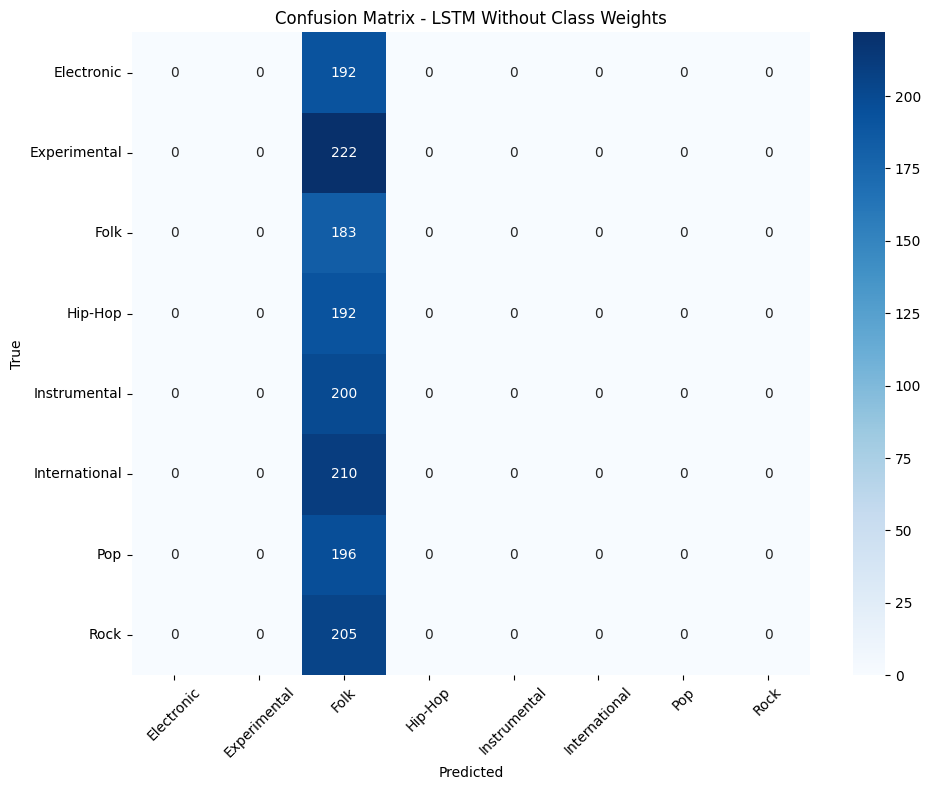

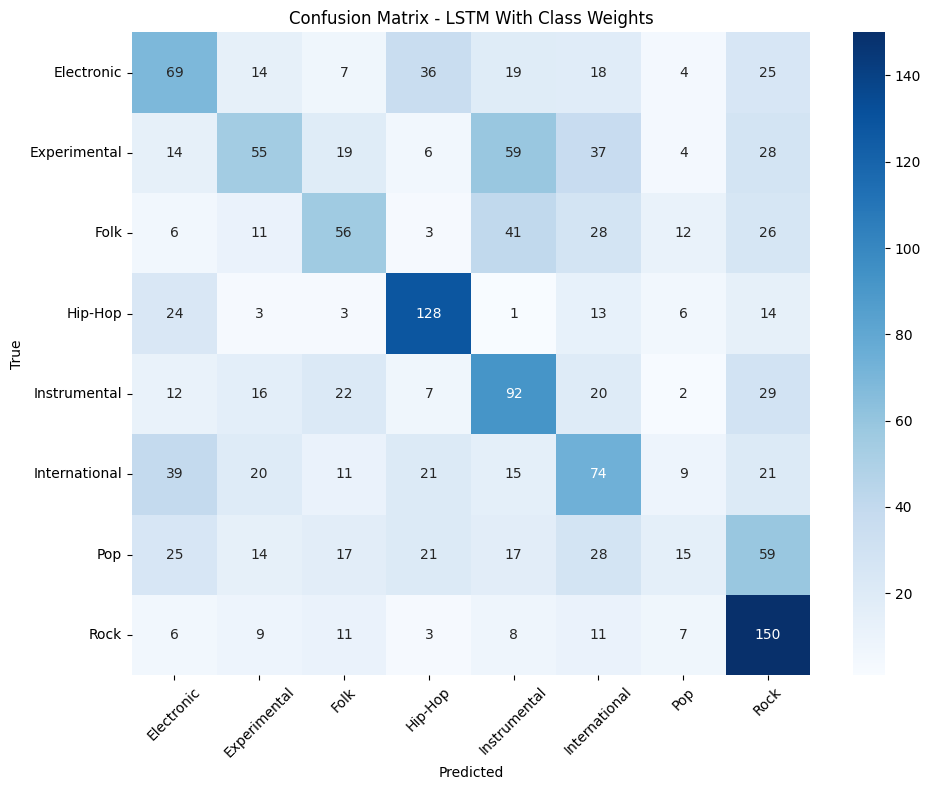

In [72]:
evaluate_and_plot('../models/lstm_genre_classifier.pth', 'LSTM Without Class Weights')
evaluate_and_plot('../models/lstm_genre_classifier_with_class_weights.pth', 'LSTM With Class Weights')

### Without class weights, the LSTM defaulted to predicting “Folk” for all samples, leading to high validation accuracy but meaningless classification. After adding class weights to penalize misclassification across all genres equally, the model began to meaningfully differentiate between genres, as reflected in the improved diagonal strength in the confusion matrix and balanced class-wise metrics